In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
np.random.seed(42)

In [2]:
# Edinburgh
from data_processing import read_edinburgh_data 
data, agent_ids = read_edinburgh_data()

/Users/kriis/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


reading:./OpenTraj/datasets/Edinburgh/annotations/tracks.01Sep.txt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2342/2342 [01:02<00:00, 37.30it/s]


Warning! too big dt in [Edinburgh]
finish


In [231]:
# Sample train and test data for pos_x and pos_y, each slice with num_steps length
def generate_data(data, begin_idx, agent_id, num_steps=5):
    sample_x = data["pos_x"].loc[data["agent_id"]==agent_id][begin_idx:begin_idx+num_steps].values
    sample_y = data["pos_y"].loc[data["agent_id"]==agent_id][begin_idx:begin_idx+num_steps].values

    test_x = data["pos_x"].loc[data["agent_id"]==agent_id][begin_idx+num_steps:begin_idx+2*num_steps].values
    test_y = data["pos_y"].loc[data["agent_id"]==agent_id][begin_idx+num_steps:begin_idx+2*num_steps].values
    
    return sample_x, sample_y, test_x, test_y

def plot_trajectories(sample_x, sample_y, test_x, test_y, cluster_avg_x, cluster_avg_y, no_of_clusters, weights):
    plt.axes().set_aspect('equal')
        
    plt.plot(np.append(sample_x, test_x), np.append(sample_y, test_y), color='g', linewidth=3)
    plt.scatter(np.append(sample_x, test_x), np.append(sample_y, test_y), color='g', linewidth=3)

    for i in range(no_of_clusters):
        plt.plot(cluster_avg_x[i], cluster_avg_y[i])
        plt.scatter(cluster_avg_x[i][:-1], cluster_avg_y[i][:-1])
        plt.scatter(cluster_avg_x[i][-1], cluster_avg_y[i][-1], linewidth=15*weights[i])
        plt.annotate(weights[i], (cluster_avg_x[i][-1], cluster_avg_y[i][-1]))
        

    #for cluster_center in Kmean.cluster_centers_:
    #    plt.scatter(cluster_center[0], cluster_center[1], marker='s')

    plt.scatter(sample_x[0], sample_y[0], color='b')

    plt.show()
    
def calculate_FDE(pred_x, pred_y, test_x, test_y):

    final_displacement_x = pred_x[-1] - test_x[-1]
    final_displacement_y = pred_y[-1] - test_y[-1]
    FDE = np.sqrt(final_displacement_x**2 + final_displacement_y**2)
    
    return FDE

In [222]:
def gen_preds_with_normal_noise(sample_x, sample_y, noise_var):
    sample_vel_x = [(sample_x[i] - sample_x[i-1]) + np.random.normal(0, noise_var) for i in range(1, len(sample_x))]
    sample_vel_y = [(sample_y[i] - sample_y[i-1]) + np.random.normal(0, noise_var) for i in range(1, len(sample_y))]
    
    avg_vel_x = np.mean(sample_vel_x)
    avg_vel_y = np.mean(sample_vel_y)
    
    pred_x = [sample_x[-1] + i*avg_vel_x for i in range(1, 6)]
    pred_y = [sample_y[-1] + i*avg_vel_y for i in range(1, 6)]
    
    return pred_x, pred_y

def avg_acc_const(sample_x, sample_y, noise_var):
    sample_vel_x = [sample_x[i] - sample_x[i-1] + np.random.normal(0, noise_var) for i in range(1, len(sample_x))]
    sample_vel_y = [sample_y[i] - sample_y[i-1] + np.random.normal(0, noise_var) for i in range(1, len(sample_y))]
    
    sample_acceleration_x = [sample_vel_x[i] - sample_vel_x[i-1] for i in range(1, len(sample_vel_x))]
    sample_acceleration_y = [sample_vel_y[i] - sample_vel_y[i-1] for i in range(1, len(sample_vel_y))]
    
    avg_acceleration_x = np.mean(sample_acceleration_x)
    avg_acceleration_y = np.mean(sample_acceleration_y)

    last_vel_x = sample_vel_x[-1]
    last_vel_y = sample_vel_y[-1]
    
    pred_x = [sample_x[-1] + last_vel_x + avg_acceleration_x]
    pred_y = [sample_y[-1] + last_vel_y + avg_acceleration_y]
    for i in range(1, 5):
        pred_x.append(pred_x[i-1] + last_vel_x + i * avg_acceleration_x)
        pred_y.append(pred_y[i-1] + last_vel_y + i * avg_acceleration_y)
        
    return pred_x, pred_y

def gen_acc_preds_with_normal_noise(sample_x, sample_y, noise_var):
    sample_vel_x = [(sample_x[i] - sample_x[i-1]) + np.random.normal(0, noise_var) for i in range(1, len(sample_x))]
    sample_vel_y = [(sample_y[i] - sample_y[i-1]) + np.random.normal(0, noise_var) for i in range(1, len(sample_y))]
    
    sample_acceleration_x = [sample_vel_x[i] - sample_vel_x[i-1] for i in range(1, len(sample_vel_x))]
    sample_acceleration_y = [sample_vel_y[i] - sample_vel_y[i-1] for i in range(1, len(sample_vel_y))]
    
    avg_acceleration_x = np.mean(sample_acceleration_x)
    avg_acceleration_y = np.mean(sample_acceleration_y)

    last_vel_x = sample_vel_x[-1]
    last_vel_y = sample_vel_y[-1]
    
    pred_x = [sample_x[-1] + last_vel_x + avg_acceleration_x]
    pred_y = [sample_y[-1] + last_vel_y + avg_acceleration_y]
    for i in range(1, 5):
        pred_x.append(pred_x[i-1] + last_vel_x + i * avg_acceleration_x)
        pred_y.append(pred_y[i-1] + last_vel_y + i * avg_acceleration_y)
        
    return pred_x, pred_y

In [166]:
def get_clustered_averages(all_pred_x, all_pred_y, no_of_clusters, cluster_labels):
    no_of_elements_per_cluster = []
    for i in range(no_of_clusters):
        no_of_elements_per_cluster.append((cluster_labels == i).sum())
    
    clustered_preds_x = [[] for _ in range(no_of_clusters)]
    clustered_preds_y = [[] for _ in range(no_of_clusters)]

    for idx, cluster_label in enumerate(cluster_labels):
        clustered_preds_x[cluster_label].append(all_pred_x[idx])
        clustered_preds_y[cluster_label].append(all_pred_y[idx])
        
    cluster_avg_x = [[] for _ in range(no_of_clusters)]
    cluster_avg_y = [[] for _ in range(no_of_clusters)]
    
    for i in range(no_of_clusters):
        cluster_avg_x[i] = np.mean(clustered_preds_x[i], axis=0)
        cluster_avg_y[i] = np.mean(clustered_preds_y[i], axis=0)
        
    return cluster_avg_x, cluster_avg_y, no_of_elements_per_cluster

## Average velocity

### Min FDE

In [167]:
from sklearn.cluster import KMeans

def avg_vel_const_gaussian_noise(data, agent_id, no_of_clusters=5, plotting=False):
    sample_x, sample_y, test_x, test_y = generate_data(data, 0, agent_id, 5)
    
    final_points = []
    # generate 100 trajectories with noise
    all_pred_x = []
    all_pred_y = []
    for i in range(100):
        pred_x, pred_y = gen_preds_with_normal_noise(sample_x, sample_y, 0.1)
        all_pred_x.append(pred_x)
        all_pred_y.append(pred_y)
        final_points.append([pred_x[-1], pred_y[-1]])
    
    Kmean = KMeans(n_clusters=no_of_clusters)
    Kmean.fit(final_points)

    cluster_avg_x, cluster_avg_y, no_of_elements_per_cluster = get_clustered_averages(all_pred_x, all_pred_y, no_of_clusters, Kmean.labels_)
    cluster_probabilities = [float(i)/sum(no_of_elements_per_cluster) for i in no_of_elements_per_cluster]

    if plotting:
        plot_trajectories(sample_x, sample_y, test_x, test_y, cluster_avg_x, cluster_avg_y, no_of_clusters)
        
    cluster_FDEs = []
    for cluster in range(no_of_clusters):
        FDE = calculate_FDE(cluster_avg_x[cluster], cluster_avg_y[cluster], test_x, test_y)
        cluster_FDEs.append(FDE)
        
    # return the minimum FDE
    # max_probability_idx = np.argmax(cluster_probabilities)
    return min(cluster_FDEs)

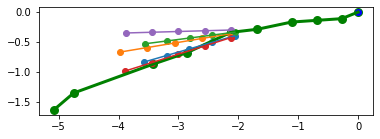

Min FDE:  1.3624003720990059


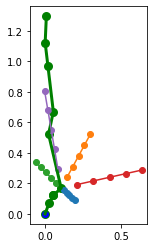

Min FDE:  0.4872530068159283


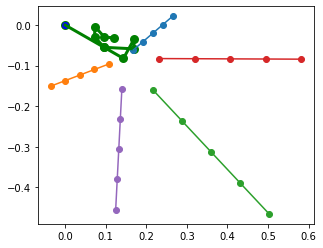

Min FDE:  0.15296947930943922


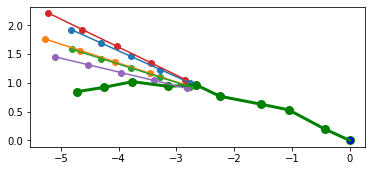

Min FDE:  0.7083574794571181


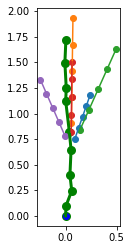

Min FDE:  0.2203127643633086


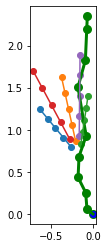

Min FDE:  0.47016204643560544


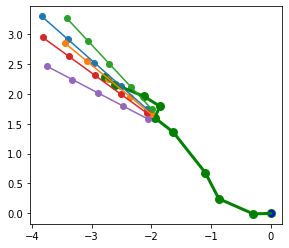

Min FDE:  0.8747981831668614


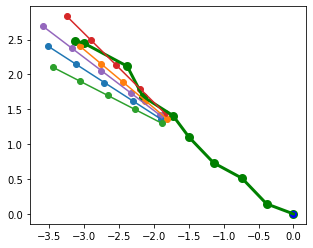

Min FDE:  0.09351463736429527


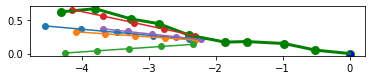

Min FDE:  0.1801800346777725


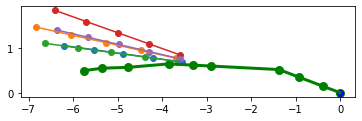

Min FDE:  0.7212645591531904


In [168]:
for i in agent_ids[:10]:
    fde = avg_vel_const_gaussian_noise(data, i, plotting=True)
    print("Min FDE: ", fde)

### Weighted FDE

In [232]:
from sklearn.cluster import KMeans

def avg_vel_const_gaussian_noise_weighted_fde(data, agent_id, no_of_clusters=5, plotting=False, noise=0.1):
    sample_x, sample_y, test_x, test_y = generate_data(data, 0, agent_id, 5)
    
    final_points = []
    # generate 100 trajectories with noise
    all_pred_x = []
    all_pred_y = []
    for i in range(100):
        pred_x, pred_y = gen_preds_with_normal_noise(sample_x, sample_y, noise)
        all_pred_x.append(pred_x)
        all_pred_y.append(pred_y)
        final_points.append([pred_x[-1], pred_y[-1]])
    
    Kmean = KMeans(n_clusters=no_of_clusters)
    Kmean.fit(final_points)

    cluster_avg_x, cluster_avg_y, no_of_elements_per_cluster = get_clustered_averages(all_pred_x, all_pred_y, no_of_clusters, Kmean.labels_)
    cluster_probabilities = [float(i)/sum(no_of_elements_per_cluster) for i in no_of_elements_per_cluster]
    print(cluster_probabilities)

    if plotting:
        plot_trajectories(sample_x, sample_y, test_x, test_y, cluster_avg_x, cluster_avg_y, no_of_clusters, cluster_probabilities)
        
    cluster_FDEs = []
    for cluster in range(no_of_clusters):
        FDE = calculate_FDE(cluster_avg_x[cluster], cluster_avg_y[cluster], test_x, test_y)
        cluster_FDEs.append(FDE)
        
    # sort the weights/probabilities to be monotonically increasing
    sorting_order = np.argsort(cluster_probabilities)
    cluster_probabilities = np.array(cluster_probabilities)[sorting_order]
    cluster_FDEs = np.array(cluster_FDEs)[sorting_order]
    cluster_avg_x = np.array(cluster_avg_x)[sorting_order]
    cluster_avg_y = np.array(cluster_avg_y)[sorting_order]
    #cluster_probabilities = [0.2, 0.2, 0.2, 0.2, 0.2]
    # calculate weighted FDE
    prev_w = 0
    weighted_FDE = 0
    for n in range(no_of_clusters):
        weighted_FDE += (no_of_clusters-n) * (cluster_probabilities[n] - prev_w) * min(cluster_FDEs[n:])
        prev_w = cluster_probabilities[n]
        
    # return the highest probability trajectory FDE
    max_probability_idx = np.argmax(cluster_probabilities)
    
    min_FDE = min(cluster_FDEs)
    
    #print(cluster_FDEs)
    #print(cluster_probabilities)
    return weighted_FDE, min_FDE

Index:  0
[0.21, 0.22, 0.24, 0.27, 0.06]


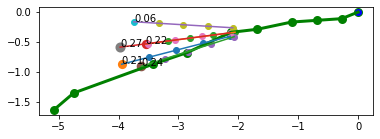

Weighted FDE:  1.3816159780998896
Min FDE:  1.3658548376951762

Index:  1
[0.24, 0.13, 0.18, 0.26, 0.19]


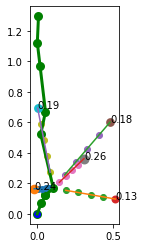

Weighted FDE:  0.6485493473194439
Min FDE:  0.6032446928918772

Index:  2
[0.18, 0.14, 0.23, 0.11, 0.34]


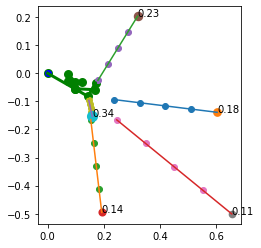

Weighted FDE:  0.12795428212799712
Min FDE:  0.12795428212799712

Index:  3
[0.25, 0.23, 0.21, 0.1, 0.21]


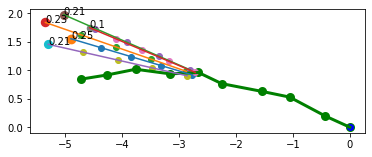

Weighted FDE:  0.7311578962373245
Min FDE:  0.7311578962373246

Index:  4
[0.28, 0.3, 0.16, 0.09, 0.17]


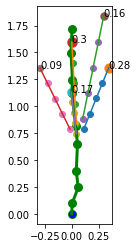

Weighted FDE:  0.12628336336360527
Min FDE:  0.12628336336360527

Index:  5
[0.36, 0.18, 0.24, 0.16, 0.06]


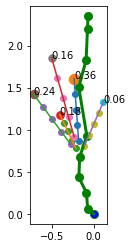

Weighted FDE:  0.688762658975719
Min FDE:  0.6590920364939711

Index:  6
[0.18, 0.09, 0.27, 0.17, 0.29]


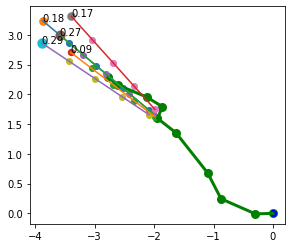

Weighted FDE:  0.9382229501591759
Min FDE:  0.7562689698276083

Index:  7
[0.25, 0.28, 0.11, 0.26, 0.1]


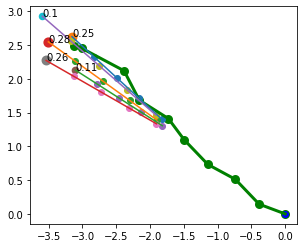

Weighted FDE:  0.1538001200409174
Min FDE:  0.14433001944225846

Index:  8
[0.34, 0.27, 0.13, 0.12, 0.14]


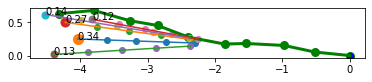

Weighted FDE:  0.18209492389548182
Min FDE:  0.1605956194245005

Index:  9
[0.17, 0.2, 0.18, 0.18, 0.27]


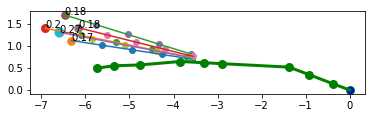

Weighted FDE:  0.8919760287645163
Min FDE:  0.8500321031815186



In [234]:
all_w_FDE = []
all_min_FDE = []

for i in agent_ids[:10]:
    print("Index: ", i)
    w_fde, min_fde = avg_vel_const_gaussian_noise_weighted_fde(data, i, plotting=True, noise=0.1)
    
    all_w_FDE.append(w_fde)
    all_min_FDE.append(min_fde)
    print("Weighted FDE: ", w_fde)
    print("Min FDE: ", min_fde)
    print()

In [204]:
corr = np.corrcoef(all_w_FDE, all_min_FDE)

In [205]:
print(corr)

[[1.         0.99911435]
 [0.99911435 1.        ]]


In [214]:
cluster_probabilities = [0.18, 0.1, 0.35, 0.17, 0.2]
cluster_FDEs = [0.51281832, 0.62987848, 0.32487596, 0.47890363, 0.16354907]
#[0.1  0.17 0.18 0.2  0.35]
no_of_clusters = 5
prev_w = 0
weighted_FDE = 0
for n in range(no_of_clusters):
    term = (no_of_clusters-n) * (cluster_probabilities[n] - prev_w) * min(cluster_FDEs[n:])
    print(term)
    weighted_FDE += term
    prev_w = cluster_probabilities[n]
    
min_FDE = min(cluster_FDEs)
print(min_FDE)
print(weighted_FDE)

0.147194163
-0.05233570239999999
0.12266180249999997
-0.058877665199999984
0.0049064721
0.16354907
0.16354907


In [235]:
from sklearn.cluster import KMeans

def avg_acc_const_gaussian_noise_weighted_fde(data, agent_id, no_of_clusters=5, plotting=False, noise=0.1):
    sample_x, sample_y, test_x, test_y = generate_data(data, 0, agent_id, 5)
    
    final_points = []
    # generate 100 trajectories with noise
    all_pred_x = []
    all_pred_y = []
    for i in range(100):
        pred_x, pred_y = avg_acc_const(sample_x, sample_y, noise)
        all_pred_x.append(pred_x)
        all_pred_y.append(pred_y)
        final_points.append([pred_x[-1], pred_y[-1]])
    
    Kmean = KMeans(n_clusters=no_of_clusters)
    Kmean.fit(final_points)

    cluster_avg_x, cluster_avg_y, no_of_elements_per_cluster = get_clustered_averages(all_pred_x, all_pred_y, no_of_clusters, Kmean.labels_)
    cluster_probabilities = [float(i)/sum(no_of_elements_per_cluster) for i in no_of_elements_per_cluster]
    print(cluster_probabilities)

    if plotting:
        plot_trajectories(sample_x, sample_y, test_x, test_y, cluster_avg_x, cluster_avg_y, no_of_clusters, cluster_probabilities)
        
    cluster_FDEs = []
    for cluster in range(no_of_clusters):
        FDE = calculate_FDE(cluster_avg_x[cluster], cluster_avg_y[cluster], test_x, test_y)
        cluster_FDEs.append(FDE)
        
    # sort the weights/probabilities to be monotonically increasing
    sorting_order = np.argsort(cluster_probabilities)
    cluster_probabilities = np.array(cluster_probabilities)[sorting_order]
    cluster_FDEs = np.array(cluster_FDEs)[sorting_order]
    cluster_avg_x = np.array(cluster_avg_x)[sorting_order]
    cluster_avg_y = np.array(cluster_avg_y)[sorting_order]
    #cluster_probabilities = [0.2, 0.2, 0.2, 0.2, 0.2]
    # calculate weighted FDE
    prev_w = 0
    weighted_FDE = 0
    for n in range(no_of_clusters):
        weighted_FDE += (no_of_clusters-n) * (cluster_probabilities[n] - prev_w) * min(cluster_FDEs[n:])
        prev_w = cluster_probabilities[n]
        
    # return the highest probability trajectory FDE
    max_probability_idx = np.argmax(cluster_probabilities)
    
    min_FDE = min(cluster_FDEs)
    
    #print(cluster_FDEs)
    #print(cluster_probabilities)
    return weighted_FDE, min_FDE

Index:  0
[0.39, 0.15, 0.21, 0.21, 0.04]


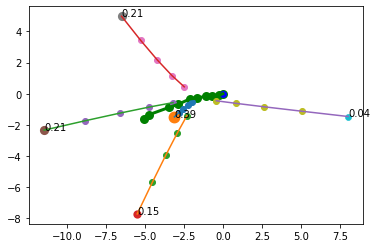

Weighted FDE:  1.981852554562955
Min FDE:  1.9818525545629553

[0.34, 0.23, 0.11, 0.09, 0.23]


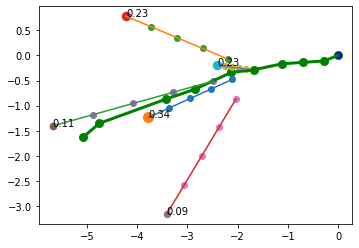

Weighted FDE:  0.9780785923620361
Min FDE:  0.6379186445918051

Index:  1
[0.25, 0.25, 0.21, 0.12, 0.17]


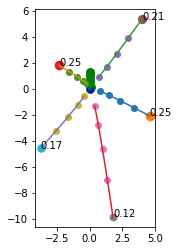

Weighted FDE:  2.4178761555117894
Min FDE:  2.4178761555117894

[0.2, 0.16, 0.3, 0.13, 0.21]


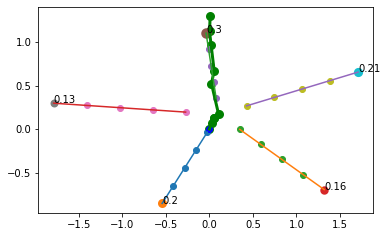

Weighted FDE:  0.19929188935868558
Min FDE:  0.19929188935868555

Index:  2
[0.29, 0.3, 0.09, 0.13, 0.19]


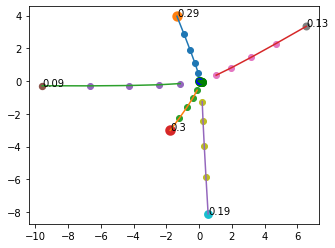

Weighted FDE:  3.529166647310432
Min FDE:  3.529166647310433

[0.16, 0.26, 0.23, 0.08, 0.27]


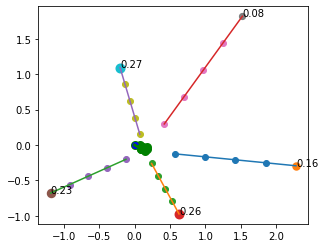

Weighted FDE:  1.068394847336072
Min FDE:  1.0673550494745991

Index:  3
[0.11, 0.12, 0.34, 0.24, 0.19]


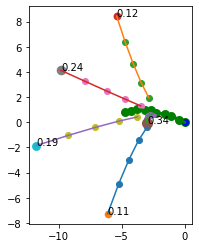

Weighted FDE:  1.9410551785677448
Min FDE:  1.9410551785677448

[0.07, 0.33, 0.16, 0.23, 0.21]


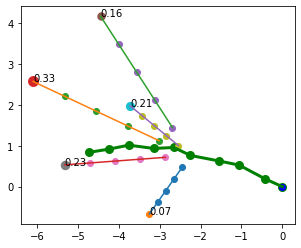

Weighted FDE:  0.8312058453579307
Min FDE:  0.677138035109054

Index:  4
[0.17, 0.21, 0.1, 0.26, 0.26]


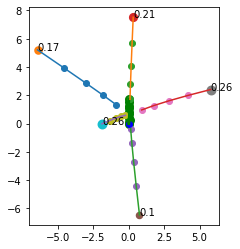

Weighted FDE:  2.5758109464739993
Min FDE:  2.5758109464739993

[0.25, 0.29, 0.21, 0.12, 0.13]


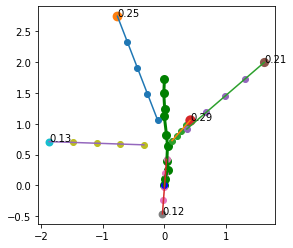

Weighted FDE:  0.7850910954109803
Min FDE:  0.7850910954109802

Index:  5
[0.18, 0.18, 0.17, 0.2, 0.27]


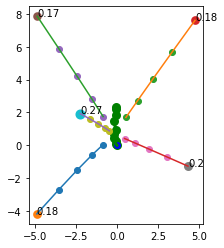

Weighted FDE:  2.2108390871748997
Min FDE:  2.2108390871748997

[0.27, 0.19, 0.29, 0.15, 0.1]


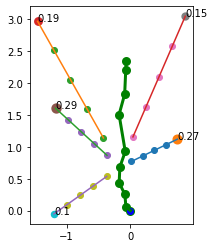

Weighted FDE:  1.2146265213831229
Min FDE:  1.1633746596076682

Index:  6
[0.19, 0.2, 0.3, 0.17, 0.14]


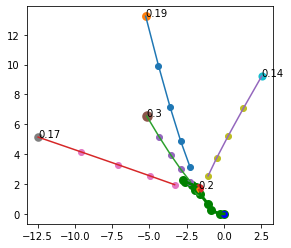

Weighted FDE:  1.5800072902523086
Min FDE:  1.211356103040186

[0.22, 0.3, 0.21, 0.17, 0.1]


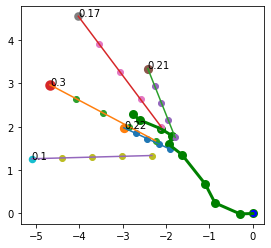

Weighted FDE:  0.5049413670532631
Min FDE:  0.3726011775225007

Index:  7
[0.22, 0.27, 0.18, 0.15, 0.18]


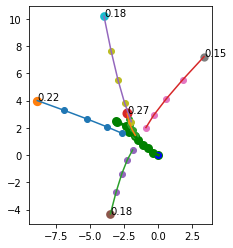

Weighted FDE:  1.0260271884119057
Min FDE:  1.0260271884119057

[0.36, 0.18, 0.21, 0.23, 0.02]


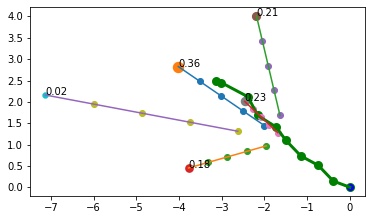

Weighted FDE:  0.8361704562087457
Min FDE:  0.8188949603745339

Index:  8
[0.21, 0.17, 0.15, 0.18, 0.29]


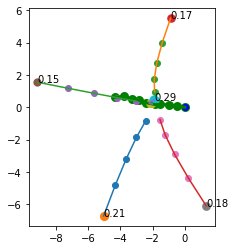

Weighted FDE:  2.4136398769387313
Min FDE:  2.4136398769387313

[0.24, 0.21, 0.2, 0.21, 0.14]


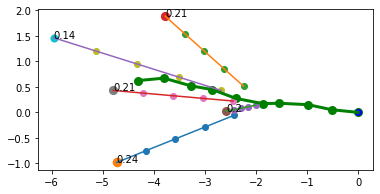

Weighted FDE:  0.5487493150532816
Min FDE:  0.5145350173162389

Index:  9
[0.24, 0.3, 0.12, 0.11, 0.23]


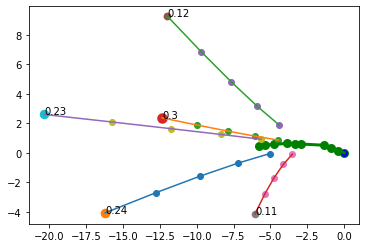

Weighted FDE:  5.641303562074233
Min FDE:  4.643850276526027

[0.23, 0.19, 0.3, 0.1, 0.18]


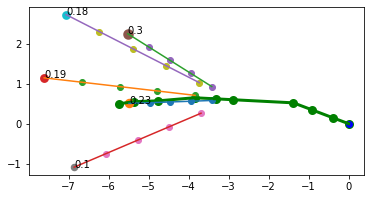

Weighted FDE:  0.36374957365585664
Min FDE:  0.25822519226507773



In [240]:
all_w_FDE = []
all_min_FDE = []
noise = 0.5

for i in agent_ids[:10]:
    print("Index: ", i)
    w_fde, min_fde = avg_acc_const_gaussian_noise_weighted_fde(data, i, plotting=True, noise=noise)
    
    all_w_FDE.append(w_fde)
    all_min_FDE.append(min_fde)
    print("Weighted FDE: ", w_fde)
    print("Min FDE: ", min_fde)
    print()
    
    w_fde, min_fde = avg_vel_const_gaussian_noise_weighted_fde(data, i, plotting=True, noise=noise)
    
    all_w_FDE.append(w_fde)
    all_min_FDE.append(min_fde)
    print("Weighted FDE: ", w_fde)
    print("Min FDE: ", min_fde)
    print()
    print("=======================")